# Development

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
import pickle
import warnings

warnings.filterwarnings("ignore")

In [2]:
df_insuarance = pd.read_csv('insurance.csv')
df_insuarance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
df_insuarance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [4]:
df_insuarance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Considering the target column is continous in nature, a regression approach is requred in conducting predictive analysis on the data.

<AxesSubplot:ylabel='Frequency'>

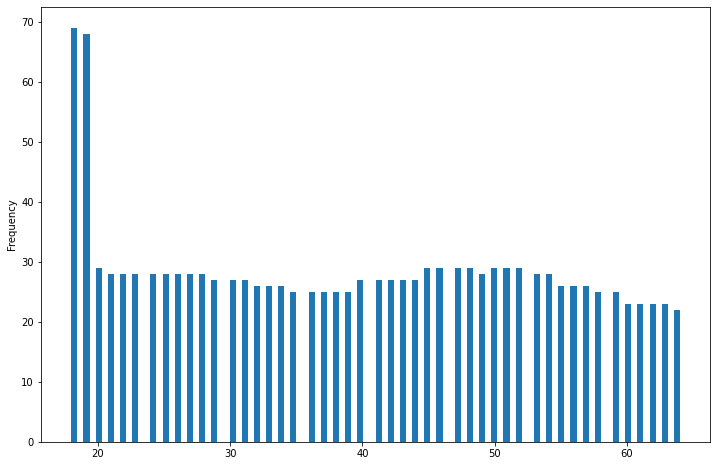

In [5]:
df_insuarance['age'].plot(kind = 'hist', figsize = (12, 8), bins = 100)

Majority of the individuals captured in the data are below 20 years of age. As from 30 to 70 years of age, there was a balance of the individuals in the data.

In [6]:
numerical_continuous = []
for column in df_insuarance.columns:
    if df_insuarance[column].dtypes != 'object':
        if df_insuarance[column].nunique() >= 10:
            numerical_continuous.append(column)
numerical_continuous.remove('charges')
numerical_continuous

['age', 'bmi']

In [7]:
numerical_discrete = []
for column in df_insuarance.columns:
    if df_insuarance[column].dtypes != 'object':
        if df_insuarance[column].nunique() < 10:
            numerical_discrete.append(column)
numerical_discrete

['children']

<AxesSubplot:>

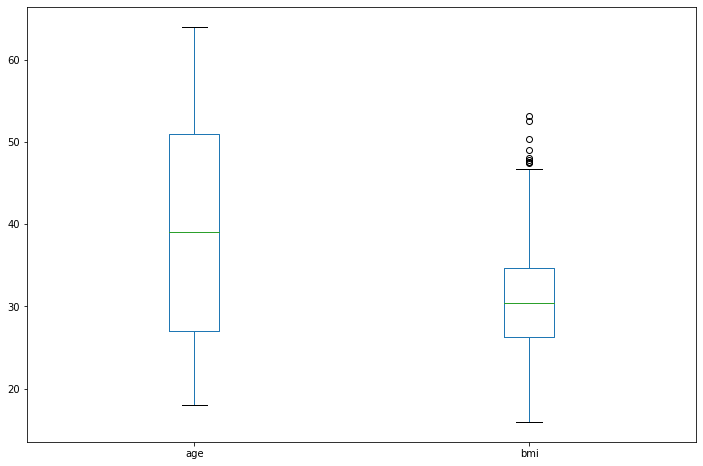

In [8]:
df_insuarance[numerical_continuous].plot(kind = 'box', figsize = (12, 8))

<AxesSubplot:>

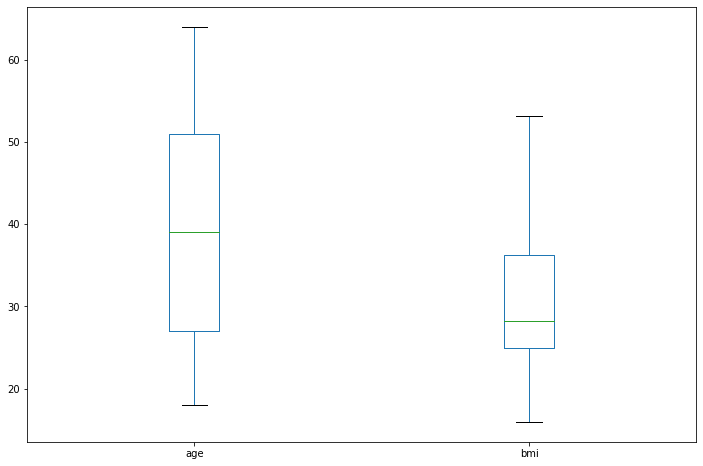

In [9]:
threshold = 0.3705
zscore = np.abs(stats.zscore(df_insuarance[['bmi']]))
df_insuarance[(zscore > threshold).all(axis=1)][numerical_continuous].plot(kind = 'box', figsize = (12, 8))

In [10]:
df_insuarance = df_insuarance[(zscore > threshold).all(axis = 1)]

In [11]:
categorical = []
for column in df_insuarance.columns:
    if df_insuarance[column].dtypes == 'object':
        categorical.append(column)
categorical

['sex', 'smoker', 'region']

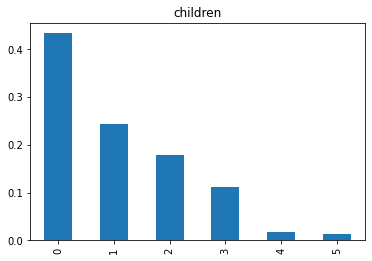

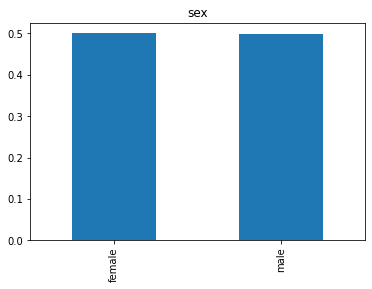

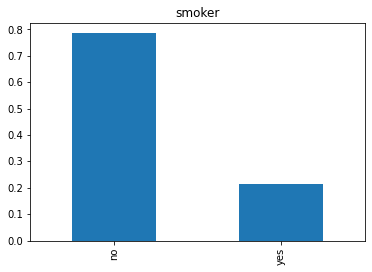

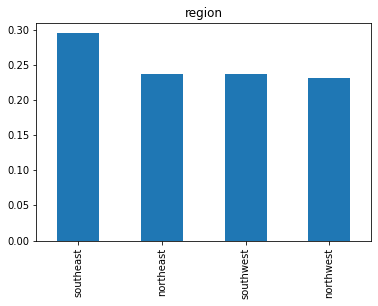

In [12]:
import matplotlib.pyplot as plt
for column in numerical_discrete + categorical:
    (df_insuarance[column].value_counts()/df_insuarance[column].shape[0]).plot(kind = 'bar')
    plt.title(column)
    plt.show()

In [13]:
df_insuarance['children'] = df_insuarance['children'].replace([3, 4, 5], 'Rare')

In [14]:
#mode
#mean
#median

encoded_features = {}
for column in numerical_discrete + categorical:
    encoded_features[column] = df_insuarance.groupby([column])['charges'].median().to_dict()
    df_insuarance[column] = df_insuarance[column].map(encoded_features[column])

In [15]:
encoded_features

{'children': {0: 9644.2525, 1: 8539.671, 2: 9954.0544, 'Rare': 10977.2063},
 'sex': {'female': 9639.395250000001, 'male': 9391.346},
 'smoker': {'no': 7345.4053, 'yes': 29330.98315},
 'region': {'northeast': 9661.16525,
  'northwest': 9301.89355,
  'southeast': 9768.88825,
  'southwest': 9328.0715}}

In [16]:
X = df_insuarance.drop('charges', axis = 1)
y = df_insuarance['charges']

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(model, 5)
X_rfe = rfe.fit_transform(X, y)  
model.fit(X_rfe, y)
print(pd.Series(rfe.support_, index = X.columns))

age          True
sex          True
bmi          True
children    False
smoker       True
region       True
dtype: bool


The column *children* had to be dropped according to the RFE. This could have been as a result of the combined rare levels analysis that could have compromised the integrity of the feature.

In [18]:
X = X.drop('children', axis = 1)

In [19]:
y_log = np.log(y)

Convering the targets to their respective log values is important because:
* The targets are normalized hence allowing the the ML algorithim learn from the data easier, faster and more efficently.
* The logged values handle any outlies in the targets.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y_log, test_size = 0.3, random_state = 0)

In [21]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
regular_reg = ElasticNet()
dt_reg = DecisionTreeRegressor(random_state = 0)
bag_reg = BaggingRegressor(random_state = 0) 
boost_reg = AdaBoostRegressor(random_state = 0)

models = {'ElasticNet': regular_reg, 'DecisionTreeRegressor': dt_reg, 'BaggingRegressor': bag_reg, 
          'AdaBoostRegressor': boost_reg}

In [23]:
def cross_valid(models, X, y, process = 'Training'):
    print(f'Process: {process}')
    for model_name, model in models.items():
        scores = cross_val_score(model, X, y, cv = 5)
        print(f'Model: {model_name}')
        print(f'Cross validation mean score: {round(np.mean(scores), 4)}')
        print(f'Cross validation deviation: {round(np.std(scores), 4)}')
        print('\n')

In [24]:
cross_valid(models, X_train, y_train, process = 'Training')

Process: Training
Model: ElasticNet
Cross validation mean score: 0.0955
Cross validation deviation: 0.0122


Model: DecisionTreeRegressor
Cross validation mean score: 0.6437
Cross validation deviation: 0.0494


Model: BaggingRegressor
Cross validation mean score: 0.7562
Cross validation deviation: 0.0355


Model: AdaBoostRegressor
Cross validation mean score: 0.7335
Cross validation deviation: 0.0191




In [25]:
cross_valid(models, X_test, y_test, process = 'Testing')

Process: Testing
Model: ElasticNet
Cross validation mean score: 0.0896
Cross validation deviation: 0.0222


Model: DecisionTreeRegressor
Cross validation mean score: 0.5137
Cross validation deviation: 0.0626


Model: BaggingRegressor
Cross validation mean score: 0.7101
Cross validation deviation: 0.0412


Model: AdaBoostRegressor
Cross validation mean score: 0.7095
Cross validation deviation: 0.0584




In [26]:
bag_reg.fit(X_train, y_train)

BaggingRegressor(random_state=0)

### With Unscaling

In [27]:
def model_evaluation(model, X, y):
    y_predict = np.exp(model.predict(X))
    y = np.exp(y)
    print(f'Mean Squared Error: {mean_squared_error(y, y_predict)}')
    print(f'Mean Absolute Error: {mean_absolute_error(y, y_predict)}')
    print(f'R2 Score: {r2_score(y, y_predict)}')

In [28]:
model_evaluation(bag_reg, X_train, y_train)

Mean Squared Error: 5264550.580492255
Mean Absolute Error: 1044.549187951901
R2 Score: 0.9646814231304146


In [29]:
model_evaluation(bag_reg, X_test, y_test)

Mean Squared Error: 25957508.89507468
Mean Absolute Error: 2609.6028008943945
R2 Score: 0.8202450088422872


### With Scaling

In [30]:
def model_evaluation(model, X, y):
    y_predict = model.predict(X)
    y = y
    print(f'Mean Squared Error: {mean_squared_error(y, y_predict)}')
    print(f'Mean Absolute Error: {mean_absolute_error(y, y_predict)}')
    print(f'R2 Score: {r2_score(y, y_predict)}')

In [31]:
model_evaluation(bag_reg, X_train, y_train)

Mean Squared Error: 0.028656079587686702
Mean Absolute Error: 0.09319737716329658
R2 Score: 0.9657644523615829


In [32]:
model_evaluation(bag_reg, X_test, y_test)

Mean Squared Error: 0.24521041503657304
Mean Absolute Error: 0.27363539614846283
R2 Score: 0.7313135802388393


In [33]:
pickle.dump(bag_reg, open('regression_model.pkl', 'wb'))

# Production

In [34]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import pickle
import streamlit as st
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [35]:
model = pickle.load(open('regression_model.pkl', 'rb'))
model

BaggingRegressor(random_state=0)

In [36]:
numerical_continuous = ['age', 'bmi']
numerical_discrete = ['children']
categorical = ['sex', 'smoker', 'region']

In [37]:
data = pd.read_csv('insurance.csv')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [39]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [40]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<AxesSubplot:ylabel='Frequency'>

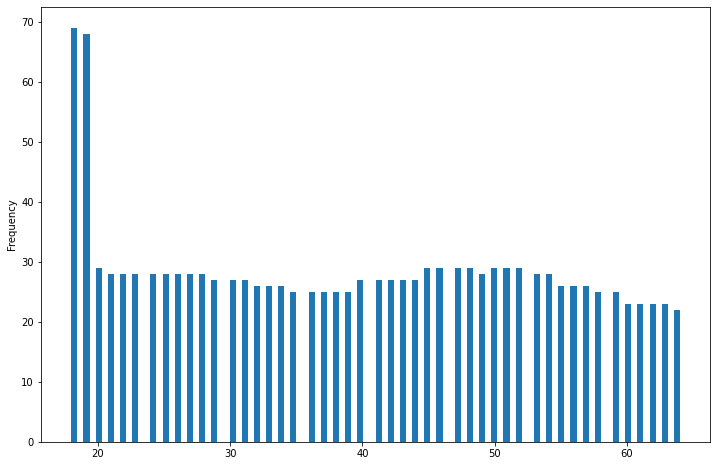

In [41]:
data['age'].plot(kind = 'hist', figsize = (12, 8), bins = 100)

<AxesSubplot:>

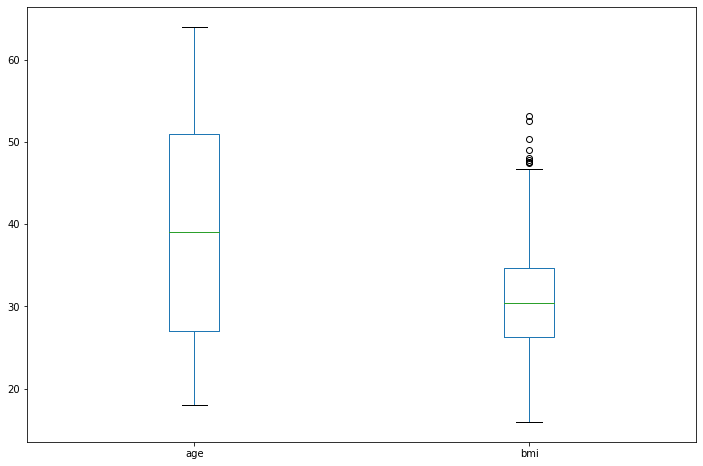

In [42]:
data[numerical_continuous].plot(kind = 'box', figsize = (12, 8))

In [43]:
def modeling(data):

    threshold = 0.3705
    zscore = np.abs(stats.zscore(data[['bmi']]))
    data = data[(zscore > threshold).all(axis = 1)]
    
    encoded_features = {}
    for column in numerical_discrete + categorical:
        encoded_features[column] = data.groupby([column])['charges'].median().to_dict()
        data[column] = data[column].map(encoded_features[column])

    X = data.drop(['children', 'charges'], axis = 1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y_predict = np.exp(model.predict(X))
    
    return pd.DataFrame(y_predict)
    

In [44]:
y_predict = modeling(data)
y_predict

,0
0,16883.678944
1,2172.273272
2,6269.580406
3,11655.481567
4,3776.250734
...,...
966,15483.012099
967,9911.753158
968,12016.466070
969,1718.037477
